# Demo of Analysis of Video and Image Data for cropping and texture features
Author(s): Miguel Xochicale @mxochicale    
Contributor(s): Tsz Yan Leung @Goosie-L


## History
* 23th August 2022: Create prototype, etc
* 13th Sep 2022: tidies methods for easier dataanalysis 
* 19th March 2023: prototype for rami2023


## Summary


### How to run the notebook
1. Go to repository path: `$HOME/repositories/`
Open repo in pycharm and in the terminal type:
```
git checkout main # or the branch
git pull # to bring a local branch up-to-date with its remote version
```

2. Launch Notebook server. Go to you repository path: cd $HOME/repositories/ and type in the pycharm terminal:
```
conda activate *VE
jupyter notebook --browser=firefox
```
which will open your web-browser.

## References 
1. https://stackoverflow.com/questions/45704999/how-to-convert-vector-wrapped-as-string-to-numpy-array-in-pandas-dataframe
2. https://github.com/YuxinZhaozyx/pytorch-VideoDataset/blob/master/datasets.py (Future work)
3. https://stackoverflow.com/questions/65446464/how-to-convert-a-video-in-numpy-array
4. https://matplotlib.org/stable/gallery/specialty_plots/mri_with_eeg.html#sphx-glr-gallery-specialty-plots-mri-with-eeg-py 
5. https://www.researchgate.net/publication/326881329_Medical_image_security_enhancement_using_two_dimensional_chaotic_mapping_optimized_by_self-adaptive_grey_wolf_algorithm 

    

## Setting imports and datasets paths

In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import skimage
from skimage.feature import graycomatrix, graycoprops

from typing import Tuple, List

HOME_PATH = os.path.expanduser(f'~')
USERNAME = os.path.split(HOME_PATH)[1]
REPOSITORY_PATH='repositories/mxochicale/rami-icra-2023'

###########################
###SET DATA_PATH 
DATA_PATH='data/demo_data'
# DATA_PATH='data/experiments/experiments_23-aug-2022_foetus_phantom_non_clinician'
# DATA_PATH='data/experiments/experiments_23-aug-2022_foetus_head_phantom_operator_clinician'
FULL_REPO_DATA_PATH = HOME_PATH +'/' + REPOSITORY_PATH +'/' + DATA_PATH


###########################
### experiments_23-aug-2022
#CSV_FILE = 'user01_recording01_sagital_crown2rump-heart-4CV.avi.csv'
# CSV_FILE = 'user03_recording01_sagital_crowm2rump-heart-4CV.avi.csv'

#AVI_FILE = 'user01_recording01_sagital_crown2rump-heart-4CV.avi'
# AVI_FILE = 'user03_recording01_sagital_crowm2rump-heart-4CV.avi' 

###########################
### experiments_03-aug-2022
# CSV_FILE = 'printing_sampling_numbers.avi.csv'

#Frame_height=480, frame_width=640 fps=60 
# AVI_FILE = 'user03_recording01_sagital_crowm2rump-heart-4CV.avi' ## [nframes=2460 ]
# AVI_FILE = 'printing_sampling_numbers.avi' ##96.4M [nframes=3321 ]


###########################
### experiments_23-aug-2022
AVI_FILE = 'clinical_user03_recording02_sagital_crowm2rump-heart-4CV.avi'
CSV_FILE = 'clinical_user03_recording02_sagital_crowm2rump-heart-4CV.avi.csv'


FULL_PATH_AND_AVI_FILE = os.path.join(FULL_REPO_DATA_PATH , AVI_FILE)
FULL_PATH_AND_CSV_FILE = os.path.join(FULL_REPO_DATA_PATH , CSV_FILE)


## Printing Versions and paths
print(f'PyTorch Version: {torch.__version__}')
print(f'pandas Version: {pd.__version__}')
print(f'seaborn Version: {sns.__version__}')
print(f'numpy Version: {np.__version__}')
print(f'cv2 Version: {cv2.__version__}')
print(f'skimage Version: {skimage.__version__}')

print(f'FULL_REPO_DATA_PATH: {FULL_REPO_DATA_PATH}')
print(f'FULL_PATH_AND_CSV_FILE: {FULL_PATH_AND_CSV_FILE}')
print(f'FULL_PATH_AND_AVI_FILE: {FULL_PATH_AND_AVI_FILE}')




PyTorch Version: 1.13.1.post200
pandas Version: 1.5.3
seaborn Version: 0.12.2
numpy Version: 1.24.2
cv2 Version: 4.7.0
skimage Version: 0.20.0
FULL_REPO_DATA_PATH: /home/mxochicale/repositories/mxochicale/rami-icra-2023/data/demo_data
FULL_PATH_AND_CSV_FILE: /home/mxochicale/repositories/mxochicale/rami-icra-2023/data/demo_data/clinical_user03_recording02_sagital_crowm2rump-heart-4CV.avi.csv
FULL_PATH_AND_AVI_FILE: /home/mxochicale/repositories/mxochicale/rami-icra-2023/data/demo_data/clinical_user03_recording02_sagital_crowm2rump-heart-4CV.avi


In [2]:
def msec_to_timestamp(current_timestamp: float) -> Tuple[float]:
    """
    Convert millisecond variable to a timestamp variable with the format minutes, seconds and milliseconds
    """
    minutes = int(current_timestamp / 1000 / 60)
    seconds = int(np.floor(current_timestamp / 1000) % 60)
    ms = current_timestamp - np.floor(current_timestamp / 1000) * 1000

    return minutes, seconds, '{:.3f}'.format(ms), '{:02d}:{:02d}:{:.3f}'.format(minutes, seconds, ms)

    
def masks_us_image(image_frame_array_1ch: np.ndarray) -> np.ndarray:
    """
    Hard mask pixels outside of scanning sector
    """
    mask = np.zeros_like(image_frame_array_1ch)

    #                 top-left, 
    #                     top-right, 
    #                           bottom-right
    #                                             arc 
    #                                                                         bottom-left
    
    #x_data = np.array([250, 380, 572,           454,321,165                   ,60])
    #y_data = np.array([30, 30, 320,             389,421,382                   ,320 ])
    
    
    x_data = np.array([250, 380, 572,           
                       597,580,561,537,515,491,474,436,395,366,333,293,249,207,166,     97,77,61,42  #arc
                       ,60])#bottom-left
    y_data = np.array([30, 30, 320,             
                       368,380,392,404,416,424,430,440,448,451,452,453,446,439,426,     398,388,380,366  #arc
                       ,320 ]) #bottom-left
    scan_arc_mask_v01 = np.vstack((x_data, y_data)).astype(np.int32).T

  
    ## USING 
    # (x8664VE) mx19@bioeng382-pc:~/repositories/budai4medtech/se-us-gui-pro/scripts/video-motion-data-analysis$ python croping_coordinates_video_with_opencv.py --videofile_in ../../data/experiments/experiments_16-aug-2022_a_printing_timings/printing_sampling_numbers.avi
    # EVENT_LBUTTONDOWN Coordinates: (x597, y368)
    # EVENT_LBUTTONDOWN Coordinates: (x580, y380)
    # EVENT_LBUTTONDOWN Coordinates: (x561, y392)
    # ...
    # EVENT_LBUTTONDOWN Coordinates: (x188, y435)
    # EVENT_LBUTTONDOWN Coordinates: (x151, y424)
    # EVENT_LBUTTONDOWN Coordinates: (x119, y409)
    # EVENT_LBUTTONDOWN Coordinates: (x97, y398)
    # EVENT_LBUTTONDOWN Coordinates: (x77, y388)
    # EVENT_LBUTTONDOWN Coordinates: (x61, y380)
    # EVENT_LBUTTONDOWN Coordinates: (x42, y366)


    
    #caliper_scale_mask = np.array([(1770, 120), (1810, 120), (1810, 930), (1770, 930)])
    cv2.fillPoly(mask, [scan_arc_mask_v01],
                (255, 255, 0))
    maskedImage = cv2.bitwise_and(image_frame_array_1ch, image_frame_array_1ch, mask=mask)

    return maskedImage



def GLCMs(img):
    """
    Calculating gray level co-occurrence matrices (GLCMs)
    https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_glcm.html#sphx-glr-auto-examples-features-detection-plot-glcm-py

    Haralick, RM.; Shanmugam, K., “Textural features for image classification” IEEE Transactions on systems, man, and 
    cybernetics 6 (1973): 610-621. [DOI:10.1109/TSMC.1973.4309314](https://doi.org/10.1109/TSMC.1973.4309314)
    PDF: http://haralick-org.torahcode.us/journals/TexturalFeaturesHaralickShanmugamDinstein.pdf
    google-citations: https://scholar.google.com/scholar?cites=13863271628667072083&as_sdt=2005&sciodt=0,5&hl=en
   
    """
    return graycomatrix(img,[1],[0],levels=256)

def Contrast(R):
    ct = graycoprops(R,prop='contrast')
    return ct

def Correlation(R):
    cn = graycoprops(R,prop='correlation')
    return cn

def Dissimilarity(R):
    d = graycoprops(R,prop='dissimilarity')
    return d

def Energy(R):
    e = graycoprops(R,prop='energy')
    return e

def Homogeneity(R):
    h = graycoprops(R,prop='homogeneity')
    return h

def ASM(R):
    a = graycoprops(R,prop='ASM')
    return a



def video_to_tensor(FULL_PATH_AND_AVI_FILE, start_frame_number, end_frame_number):
    cap = cv2.VideoCapture(FULL_PATH_AND_AVI_FILE)
    if cap.isOpened() == False:
        print('[ERROR] [ViewVideoDataset.__getitem__()] Unable to open video ' + FULL_PATH_AND_AVI_FILE)
        exit(-1)

    # Get parameters of input video
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(np.ceil(cap.get(cv2.CAP_PROP_FPS)))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Print video features
    print(f'  ')
    print(f'  ')
    print(f'  VIDEO_FEATURES')
    print(f'    video_name={FULL_PATH_AND_AVI_FILE}')
    print(f'    Frame_height={frame_height}, frame_width={frame_width} fps={fps} nframes={frame_count} ')
    print(f'  ')
    print(f'  ')
    # # #         if start_frame_number >= end_frame_number:
    # # #             raise Exception("start frame number must be less than end frame number")

    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame_number)
    frames_numpy_ndarray=[]
    frames_torch = []
    frames_timestamp = []

    # pbar = tqdm(total=total_number_of_frames - 1)
    while cap.isOpened():
        success, image_frame_3ch_i = cap.read()

        if not success and len(frames_torch) < 1:
            print(f'[ERROR] {FULL_PATH_AND_AVI_FILE}')
            exit(-1)
            break

        if cap.get(cv2.CAP_PROP_POS_FRAMES) >= end_frame_number:
            break

        frame_msec = cap.get(cv2.CAP_PROP_POS_MSEC)
        current_frame_timestamp = msec_to_timestamp(frame_msec)
    #     print(current_frame_timestamp)#(0, 33, '333.333', '00:33:333.333')
    #     print(current_frame_timestamp[2])#'00:33:333.333'
    #     print(current_frame_timestamp[3])#00:33:333.333


        # (H x W x C) to (C x H x W)

    #     print(type(image_frame_3ch_i))#    <class 'numpy.ndarray'>
    #     print(image_frame_3ch_i.shape)#(480, 640, 3)

        image_frame_1ch_i = cv2.cvtColor(image_frame_3ch_i, cv2.COLOR_BGR2GRAY)

    #     frames_numpy_ndarray.append(image_frame_1ch_i)
        frames_numpy_ndarray.append(masks_us_image(image_frame_1ch_i))

        frames_timestamp.append(current_frame_timestamp[3])

    #     frame_torch = torch.from_numpy(image_frame_3ch_i).float()
    #     frame_torch = frame_torch.squeeze()  # Fake batch dimension to be "H,W,C"
    #     print(type(frame_torch))#<class 'torch.Tensor'>
    #     print(frame_torch.shape)#torch.Size([480, 640, 3])

    # # #             cropped_image_frame_ = cropped_frame(masked_frame, self.crop_bounds)
    # # #             frame_torch = ToImageTensor(cropped_image_frame_)

    video = np.stack(frames_numpy_ndarray, axis=0) # dimensions (Fi, H, W, C)
    cap.release()

    return video, frames_timestamp

# Reading video and plotting frames

In [3]:
# start_frame_number = 400
# end_frame_number = 1690

start_frame_number = 400
end_frame_number = 1690

total_number_of_frames = end_frame_number - start_frame_number

In [4]:

video, frames_timestamp = video_to_tensor(FULL_PATH_AND_AVI_FILE, start_frame_number, end_frame_number)

# print(type(video))#<class 'numpy.ndarray'>
num_frames, height, width = video.shape
print(f'num_frames: {num_frames}')
print(f'height: {height}')
print(f'width: {width}')
#num_frames, height, width, channels = video.shape
# print(f'channels: {channels}')
# print(video[0].shape)#(480, 640, 3)



  
  
  VIDEO_FEATURES
    video_name=/home/mxochicale/repositories/mxochicale/rami-icra-2023/data/demo_data/clinical_user03_recording02_sagital_crowm2rump-heart-4CV.avi
    Frame_height=480, frame_width=640 fps=60 nframes=1697 
  
  
num_frames: 1289
height: 480
width: 640


frame_i: 0, timestamp 00:06:666.667


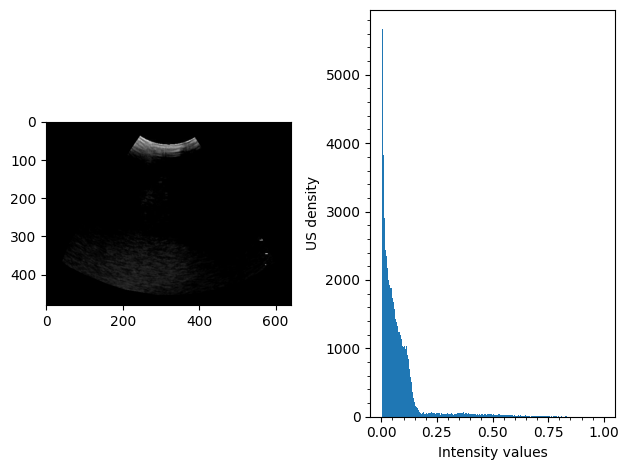

frame_i: 100, timestamp 00:08:333.333


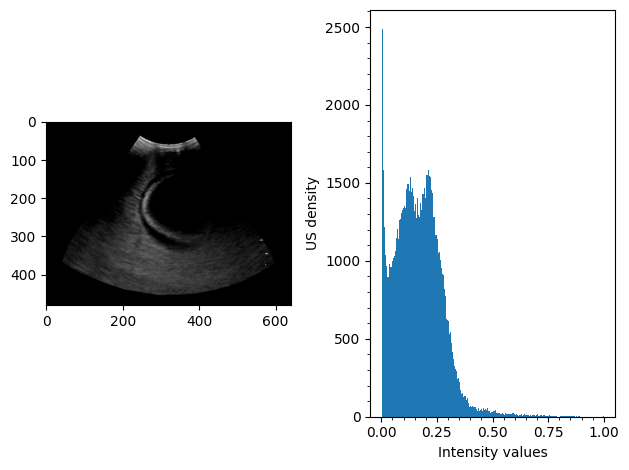

frame_i: 200, timestamp 00:10:0.000


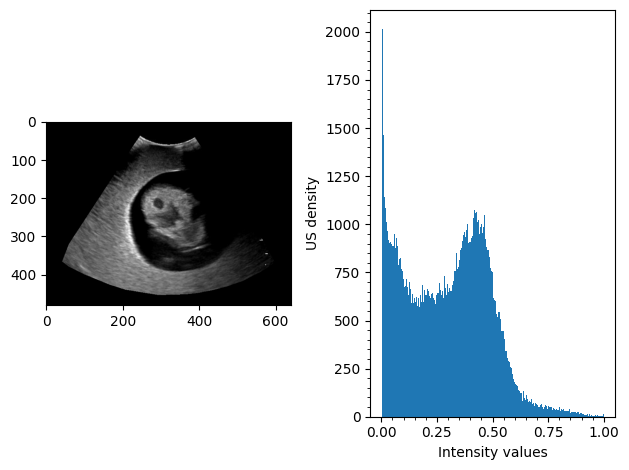

frame_i: 300, timestamp 00:11:666.667


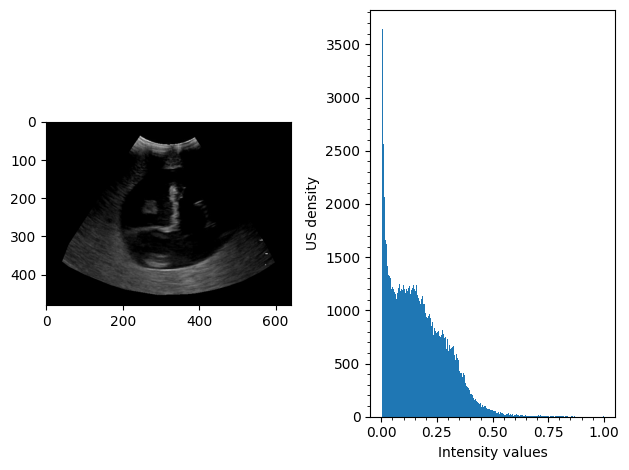

frame_i: 400, timestamp 00:13:333.333


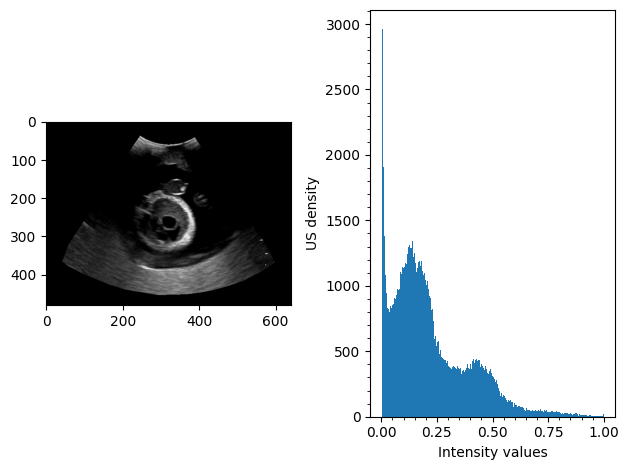

frame_i: 500, timestamp 00:15:0.000


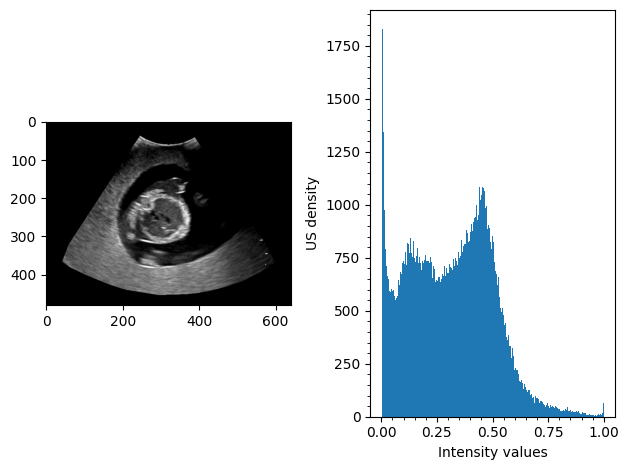

frame_i: 600, timestamp 00:16:666.667


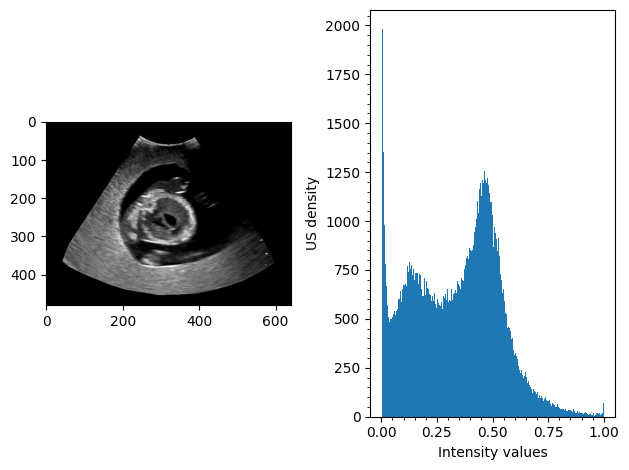

frame_i: 700, timestamp 00:18:333.333


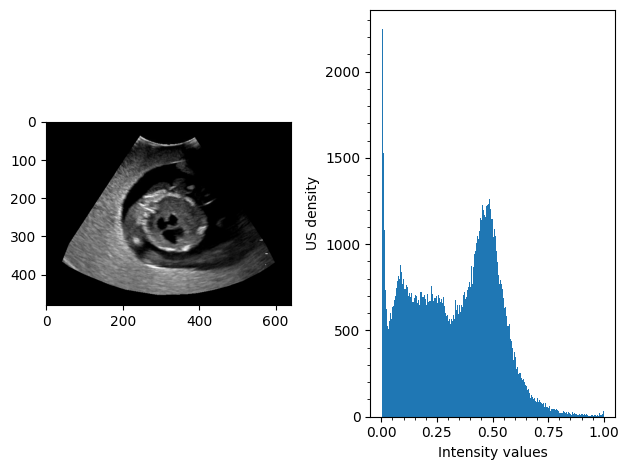

frame_i: 800, timestamp 00:20:0.000


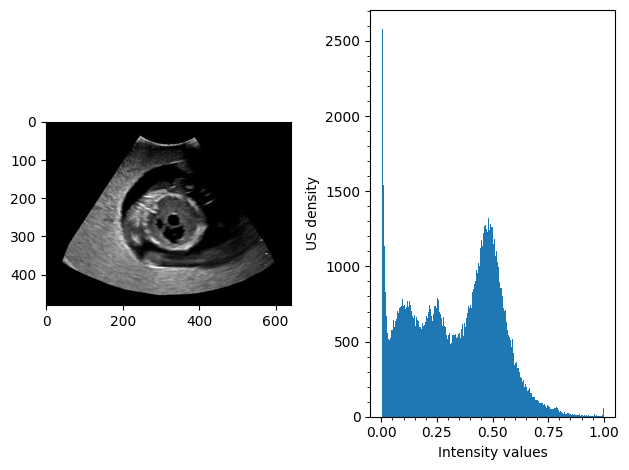

frame_i: 900, timestamp 00:21:666.667


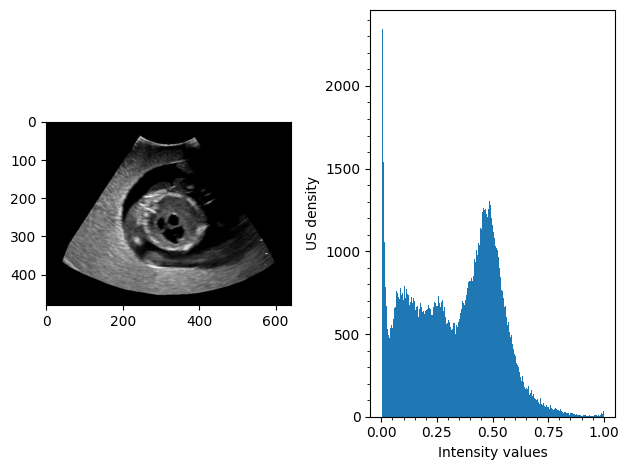

frame_i: 1000, timestamp 00:23:333.333


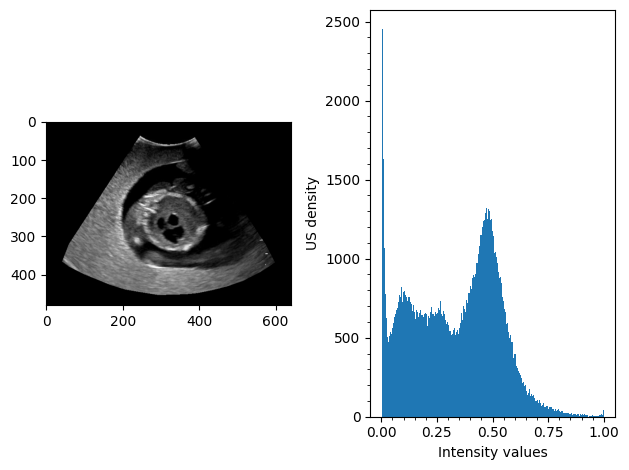

frame_i: 1100, timestamp 00:25:0.000


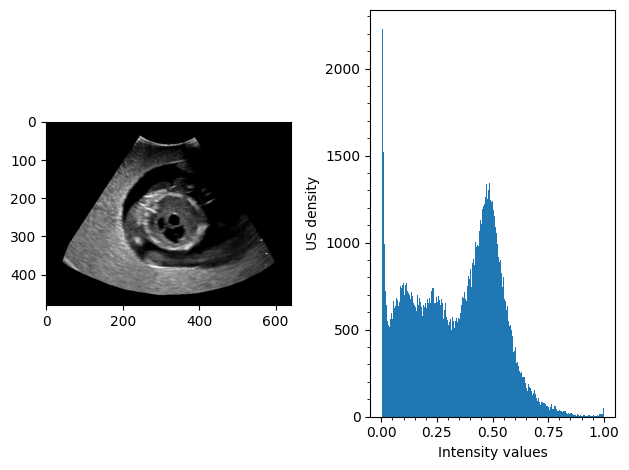

frame_i: 1200, timestamp 00:26:666.667


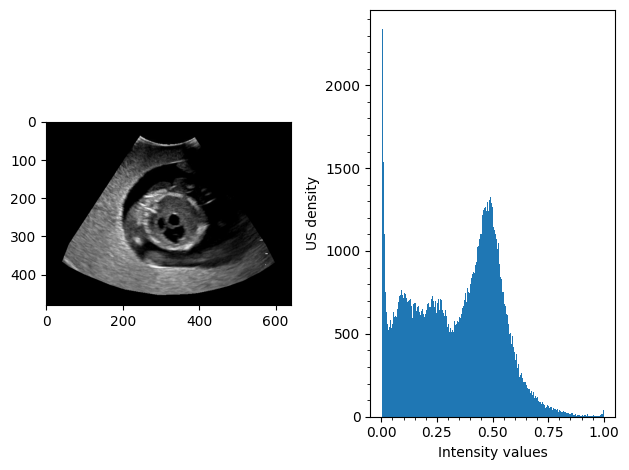

      frame_i   Contrast  Correlation  Dissimilarity    Energy  Homogeneity  \
0           0  10.131716     0.977717       0.571635  0.788007     0.871942   
1           1  11.688172     0.984124       0.826513  0.708117     0.813360   
2           2  11.688172     0.984124       0.826513  0.708117     0.813360   
3           3  11.688172     0.984124       0.826513  0.708117     0.813360   
4           4  11.688172     0.984124       0.826513  0.708117     0.813360   
...       ...        ...          ...            ...       ...          ...   
1284     1284  39.511320     0.992844       2.022946  0.589188     0.689973   
1285     1285  39.511320     0.992844       2.022946  0.589188     0.689973   
1286     1286  39.511320     0.992844       2.022946  0.589188     0.689973   
1287     1287  39.511320     0.992844       2.022946  0.589188     0.689973   
1288     1288  39.511320     0.992844       2.022946  0.589188     0.689973   

           ASM  
0     0.620955  
1     0.501430  


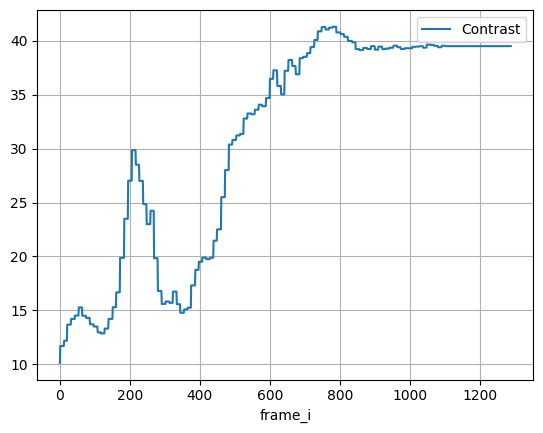

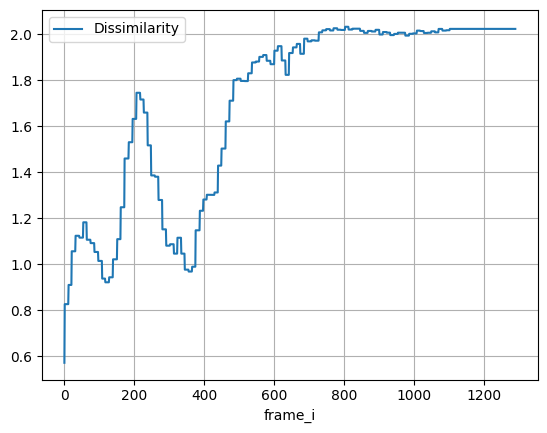

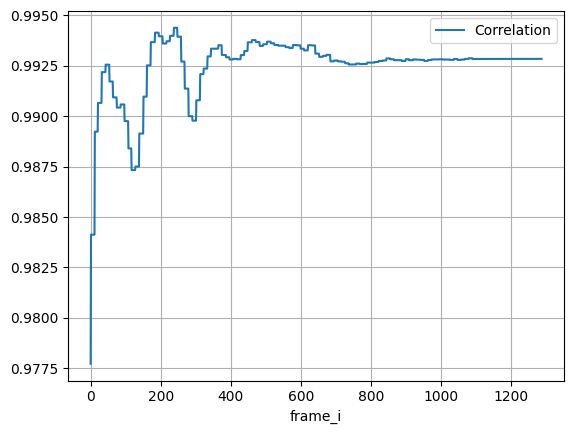

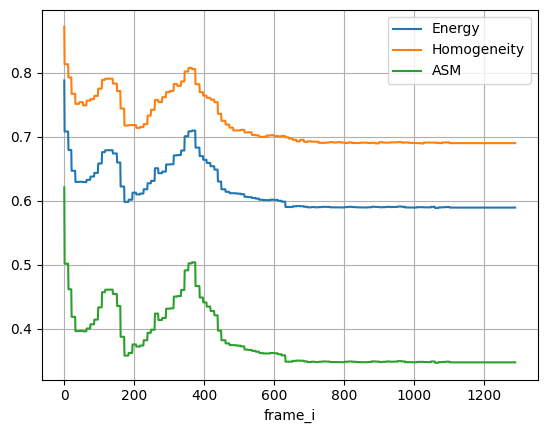

In [5]:
def display_us_hist(im):
    im=video[frame_i]
    fig = plt.figure(dpi=100)
    ax0 = fig.add_subplot(1, 2, 1)
    ax0.imshow(im, cmap='gray')

    ax1 = fig.add_subplot(1, 2, 2)
    
    #im = np.ravel(im)
    #im = im[np.nonzero(im)]  # Ignore the background
    #im = im / (2**16 - 1)  # Normalize
    #ax1.hist(im, bins=10)
    #https://matplotlib.org/stable/gallery/specialty_plots/mri_with_eeg.html#sphx-glr-gallery-specialty-plots-mri-with-eeg-py
    
    im = np.ravel(im)/256 # Normalize
    im = im[np.nonzero(im)]  # Ignore the background
    ax1.hist(im, bins=256, range=(0.0, 1.0))
    #https://matplotlib.org/stable/tutorials/introductory/images.html#sphx-glr-tutorials-introductory-images-py
    
    ax1.minorticks_on()
    ax1.set_xlabel('Intensity values')
    ax1.set_ylabel('US density')

    plt.tight_layout()
    plt.show()

    
texture_analysis_array = []    

for frame_i in range(len(video)):
    
    # Compute Grey-Level-Co-occurrence Matrix    
    R=GLCMs(video[frame_i])

    # Calculating texture property Contrast
    con = Contrast(R)

    # Calculating texture property Correlation
    cor = Correlation(R)

    # Calculating texture property Dissimilarity
    dis = Dissimilarity(R)

    # Calculating texture property Energy
    en = Energy(R)

    # Calculating texture property Homogeneity
    homo = Homogeneity(R)
    
    # Calculating texture property ASM
    asm = ASM(R)
    
    texture_analysis_array.append([con,cor,dis,en,homo,asm])
    #print(con,cor,dis,en,homo, asm) 
    

    if frame_i % 100 == 0:
        print(f'frame_i: {frame_i}, timestamp {frames_timestamp[frame_i]}')
        display_us_hist(frame_i)

    
    #plt.savefig('filename'+str(frame_i)+'.png', dpi=300)

# print(texture_analysis_array)  


    
texture_analysis_np_array = np.stack(texture_analysis_array, axis=0) 
texture_analysis_np_array = texture_analysis_np_array.transpose()
texture_analysis_np_array = texture_analysis_np_array.squeeze()
# print(texture_analysis_np_array)
# print(texture_analysis_np_array[0])

df_texture_analysis = pd.DataFrame( 
    {
        'frame_i': np.arange(0, total_number_of_frames-1),
        'Contrast': texture_analysis_np_array[0],
        'Correlation': texture_analysis_np_array[1],
        'Dissimilarity': texture_analysis_np_array[2],
        'Energy': texture_analysis_np_array[3],
        'Homogeneity': texture_analysis_np_array[4],
        'ASM': texture_analysis_np_array[5]

    }
    )
print(df_texture_analysis)


# ax = plt.gca()
# ## Comment/uncomment any of the following lines to show however axis you would like to see in the plot
# df_texture_analysis.plot( x = 'frame_i' , y = 'Contrast', ax = ax )
# df_texture_analysis.plot( x = 'frame_i' , y = 'Correlation' , ax = ax )
# df_texture_analysis.plot( x = 'frame_i' , y = 'Dissimilarity' , ax = ax )
# df_texture_analysis.plot( x = 'frame_i' , y = 'Energy' , ax = ax )
# df_texture_analysis.plot( x = 'frame_i' , y = 'Homogeneity' , ax = ax )
# df_texture_analysis.plot( x = 'frame_i' , y = 'ASM' , ax = ax )
# plt.grid()
# plt.show()

ax = plt.gca()
## Comment/uncomment any of the following lines to show however axis you would like to see in the plot
df_texture_analysis.plot( x = 'frame_i' , y = 'Contrast', ax = ax )
plt.grid()
plt.show()



ax = plt.gca()
df_texture_analysis.plot( x = 'frame_i' , y = 'Dissimilarity' , ax = ax )
plt.grid()
plt.show()

ax = plt.gca()
df_texture_analysis.plot( x = 'frame_i' , y = 'Correlation' , ax = ax )
plt.grid()
plt.show()



ax = plt.gca()
df_texture_analysis.plot( x = 'frame_i' , y = 'Energy' , ax = ax )
df_texture_analysis.plot( x = 'frame_i' , y = 'Homogeneity' , ax = ax )
df_texture_analysis.plot( x = 'frame_i' , y = 'ASM' , ax = ax )
plt.grid()
plt.show()



# #TODO: https://seaborn.pydata.org/generated/seaborn.lineplot.html

    


## Reading csv files

   Sample_number  epoch machine time (ns)  \
0              0      1661265471374886920   
1              1      1661265471418842259   
2              2      1661265471423141134   
3              3      1661265471428126400   
4              4      1661265471434271957   

   Timestamp for frame capture.read  (ns)  Timestamp LPMSB2 (s)  \
0                     1661265471375484761               4013.10   
1                     1661265471375484761               4013.11   
2                     1661265471375484761               4013.12   
3                     1661265471375484761               4013.13   
4                     1661265471375484761               4013.14   

                                  Quaternions_LPMSB2  \
0  [-0.4978141188621521, 0.056774165481328964, 0....   
1  [-0.4977661371231079, 0.05687526613473892, 0.8...   
2  [-0.4976876974105835, 0.05698489397764206, 0.8...   
3  [-0.4975792467594147, 0.0570514015853405, 0.86...   
4  [-0.497490793466568, 0.057041823863983154, 

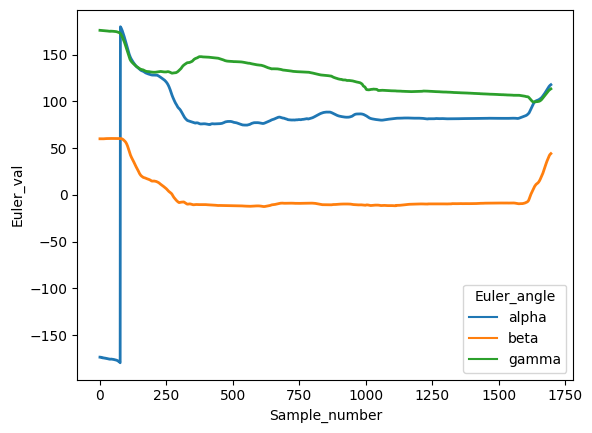

      Sample_number Quaternion     Q_val
0                 0         q0 -0.497814
1                 1         q0 -0.497766
2                 2         q0 -0.497688
3                 3         q0 -0.497579
4                 4         q0 -0.497491
...             ...        ...       ...
6787           1693         q3  0.231513
6788           1694         q3  0.228742
6789           1695         q3  0.226526
6790           1696         q3  0.224592
6791           1697         q3  0.222819

[6792 rows x 3 columns]


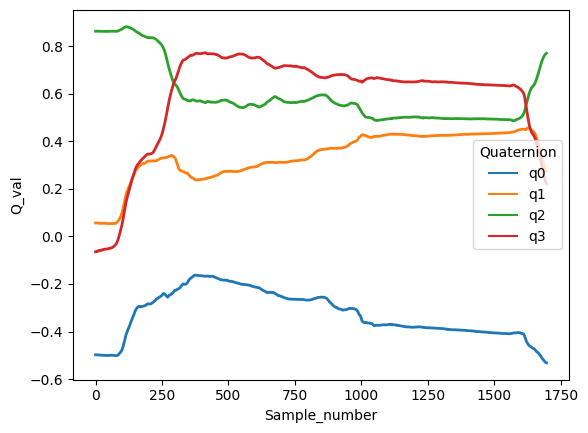

In [6]:
df=pd.read_csv(FULL_PATH_AND_CSV_FILE)
# print(df)

# # df = df.rename(columns={'Euler_computed [Roll, Pitch, Yaw]': 'Euler_computed'})
df = df.rename(columns={'Sample number': 'Sample_number'})
df = df.rename(columns={'Euler [Roll, Pitch, Yaw] LPMSB2': 'Euler_LPMSB2'})
df = df.rename(columns={'Quaternions [q0, q1, q2, q3] LPMS-B2': 'Quaternions_LPMSB2'})

df[['A','B','C']]=df.Euler_LPMSB2.str.split(',',expand=True)
df['A']=df['A'].apply(   lambda x: x.replace('[','')   )
df['C']=df['C'].apply(   lambda x:  x.replace(']','')   )
df['A'] = pd.to_numeric(df['A'], errors='coerce')
df['B'] = pd.to_numeric(df['B'], errors='coerce')
df['C'] = pd.to_numeric(df['C'], errors='coerce')

df[['q0','q1','q2', 'q3']]=df.Quaternions_LPMSB2.str.split(',',expand=True)
df['q0']=df['q0'].apply(   lambda x: x.replace('[','')   )
df['q3']=df['q3'].apply(   lambda x:  x.replace(']','')   )
df['q0'] = pd.to_numeric(df['q0'], errors='coerce')
df['q1'] = pd.to_numeric(df['q1'], errors='coerce')
df['q2'] = pd.to_numeric(df['q2'], errors='coerce')
df['q3'] = pd.to_numeric(df['q3'], errors='coerce')

print(df.head())# #Print head of csv


## EULER ANGLES
ndf_a=pd.DataFrame(data=df['Sample_number'])
ndf_a.insert(1, 'Euler_angle', str('alpha'), True)
ndf_a.insert(2, 'Euler_val', df['A'], True)

ndf_b=pd.DataFrame(data=df['Sample_number'])
ndf_b.insert(1, 'Euler_angle', str('beta'), True)
ndf_b.insert(2, 'Euler_val', df['B'], True)

ndf_c=pd.DataFrame(data=df['Sample_number'])
ndf_c.insert(1, 'Euler_angle', str('gamma'), True)
ndf_c.insert(2, 'Euler_val', df['C'], True)

ndf = pd.concat([ndf_a, ndf_b, ndf_c], ignore_index=True)
print(ndf)

sns.lineplot(data=ndf,x='Sample_number', y='Euler_val',hue='Euler_angle',lw=2)
plt.show()


## QUATERNIONS
nqdf_q0=pd.DataFrame(data=df['Sample_number'])
nqdf_q0.insert(1, 'Quaternion', str('q0'), True)
nqdf_q0.insert(2, 'Q_val', df['q0'], True)

nqdf_q1=pd.DataFrame(data=df['Sample_number'])
nqdf_q1.insert(1, 'Quaternion', str('q1'), True)
nqdf_q1.insert(2, 'Q_val', df['q1'], True)

nqdf_q2=pd.DataFrame(data=df['Sample_number'])
nqdf_q2.insert(1, 'Quaternion', str('q2'), True)
nqdf_q2.insert(2, 'Q_val', df['q2'], True)

nqdf_q3=pd.DataFrame(data=df['Sample_number'])
nqdf_q3.insert(1, 'Quaternion', str('q3'), True)
nqdf_q3.insert(2, 'Q_val', df['q3'], True)

nqdf = pd.concat([nqdf_q0, nqdf_q1, nqdf_q2, nqdf_q3], ignore_index=True)
print(nqdf)

sns.lineplot(data=nqdf,x='Sample_number', y='Q_val',hue='Quaternion',lw=2)
plt.show()